In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv('availability.csv')

df.rename(columns={'last_update': 'time_of_day'}, inplace=True)
df = df.drop(columns=["status"])
df['time_of_day'] = pd.to_datetime(df['time_of_day'])

specified_date_time = pd.to_datetime('2024-02-25 15:03:04')

df = df[df['time_of_day'] >= specified_date_time]

df2 = pd.read_csv('weather.csv')
df2['time_of_day'] = pd.to_datetime(df2['time_of_day'])
df2 = df2.drop(columns=["main"])
merged_df = pd.merge_asof(df.sort_values('time_of_day'), df2.sort_values('time_of_day'), 
                          by='station_id', on='time_of_day', direction='nearest')
merged_df['month'] = pd.to_datetime(merged_df['time_of_day']).dt.month
merged_df['day'] = pd.to_datetime(merged_df['time_of_day']).dt.day
merged_df['hour'] = pd.to_datetime(merged_df['time_of_day']).dt.hour


In [5]:


merged_df = merged_df.sort_values(by='time_of_day')    
merged_df['time_of_day'] = pd.to_datetime(merged_df['time_of_day'])

merged_df['weekday_num'] = merged_df['time_of_day'].dt.weekday + 1  # Adding 1 to match the range 1-7 (Sunday = 7)

df = merged_df
df["description"] = df["description"].astype('category')
df["station_id"] = df["station_id"].astype('category')
df = df.drop(columns=['time_of_day', "available_bike_stands"])

df

,station_id,bike_stands,available_bikes,description,temperature,wind_speed,month,day,hour,weekday_num
0,42,30,30,broken clouds,7,9.77,2,25,15,7
1,51,40,6,broken clouds,8,9.77,2,25,15,7
2,32,30,30,broken clouds,8,9.77,2,25,15,7
3,18,30,24,broken clouds,7,9.77,2,25,15,7
4,57,23,0,broken clouds,7,9.77,2,25,15,7
...,...,...,...,...,...,...,...,...,...,...
751693,21,30,3,broken clouds,8,6.17,4,2,22,2
751694,17,20,3,broken clouds,8,6.17,4,2,22,2
751695,35,30,20,broken clouds,8,6.17,4,2,22,2
751696,93,40,22,broken clouds,8,6.17,4,2,22,2


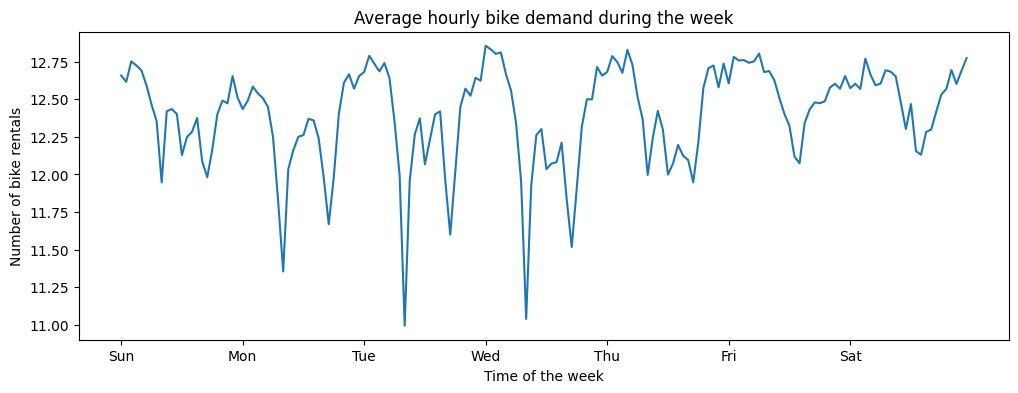

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday_num", "hour"])["available_bikes"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [7]:
X = df.drop("available_bikes", axis="columns")
X

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
0,42,30,broken clouds,7,9.77,2,25,15,7
1,51,40,broken clouds,8,9.77,2,25,15,7
2,32,30,broken clouds,8,9.77,2,25,15,7
3,18,30,broken clouds,7,9.77,2,25,15,7
4,57,23,broken clouds,7,9.77,2,25,15,7
...,...,...,...,...,...,...,...,...,...
751693,21,30,broken clouds,8,6.17,4,2,22,2
751694,17,20,broken clouds,8,6.17,4,2,22,2
751695,35,30,broken clouds,8,6.17,4,2,22,2
751696,93,40,broken clouds,8,6.17,4,2,22,2


In [8]:
y = df["available_bikes"]
y

0         30
1          6
2         30
3         24
4          0
          ..
751693     3
751694     3
751695    20
751696    22
751697     6
Name: available_bikes, Length: 751698, dtype: int64

In [67]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=0,
    max_train_size=105000,
    test_size=15000,
)

In [68]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [69]:
X.iloc[test_0]

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
676698,37,30,scattered clouds,6,4.12,3,30,2,6
676699,87,38,scattered clouds,6,4.12,3,30,2,6
676700,93,40,scattered clouds,6,4.12,3,30,2,6
676701,111,40,scattered clouds,6,4.12,3,30,2,6
676702,82,22,scattered clouds,6,4.12,3,30,2,6
...,...,...,...,...,...,...,...,...,...
691693,58,40,scattered clouds,8,3.60,3,30,20,6
691694,48,40,scattered clouds,8,3.60,3,30,20,6
691695,59,20,scattered clouds,8,3.60,3,30,20,6
691696,60,30,scattered clouds,8,3.60,3,30,20,6


In [70]:
X.iloc[train_0]

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
571698,69,40,light intensity drizzle rain,8,6.17,3,25,0,1
571699,11,30,light intensity drizzle rain,8,6.17,3,25,0,1
571700,26,20,broken clouds,8,6.17,3,25,0,1
571701,21,30,broken clouds,8,6.17,3,25,0,1
571702,116,30,broken clouds,8,6.17,3,25,0,1
...,...,...,...,...,...,...,...,...,...
676693,13,30,scattered clouds,6,4.12,3,30,2,6
676694,86,38,scattered clouds,6,4.12,3,30,2,6
676695,21,30,scattered clouds,6,4.12,3,30,2,6
676696,31,20,scattered clouds,6,4.12,3,30,2,6


In [71]:
df.dtypes

station_id     int64
bike_stands    int64
dtype: object

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

gbrt = HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=42)
categorical_columns = X.columns[X.dtypes == "category"]
print("Categorical features:", categorical_columns.tolist())

Categorical features: ['station_id', 'description']


In [73]:
import numpy as np
from sklearn.model_selection import cross_validate

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R-squared:               {r2.mean():.3f} +/- {r2.std():.3f}"
    )


evaluate(gbrt, X, y, cv=ts_cv, model_prop="n_iter_")

Mean model.n_iter_ = 100.0
Mean Absolute Error:     5.567 +/- 1.174
Root Mean Squared Error: 7.256 +/- 1.510
R-squared:               0.414 +/- 0.227


In [16]:
import pickle

fitted_model = gbrt.fit(X, y)
model_filename = 'your_model.pkl'

# Serialize and save the model to the specified file
with open(model_filename, 'wb') as file:
    pickle.dump(fitted_model, file)

print("Model saved successfully as", model_filename)

Model saved successfully as your_model.pkl


In [17]:
with open('your_model.pkl', 'rb') as file:
    model = pickle.load(file)

Mean model.n_iter_ = 100.0
Mean Absolute Error:     6.152 +/- 0.489
Root Mean Squared Error: 7.984 +/- 0.794
R-squared:               0.309 +/- 0.114


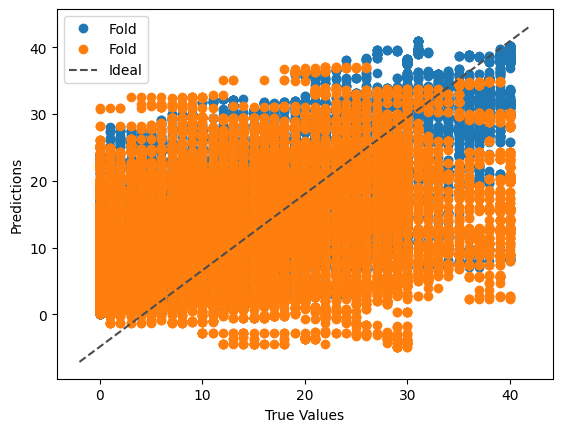

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined gbrt, X, y, and ts_cv

def plot_predictions(model, X, y, cv):
    fig, ax = plt.subplots()

    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        ax.plot(y_test, y_pred, 'o', label="Fold")
    
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label="Ideal")
    ax.legend()
    plt.show()

evaluate(gbrt, X, y, cv=ts_cv, model_prop="n_iter_")
plot_predictions(gbrt, X, y, cv=ts_cv)


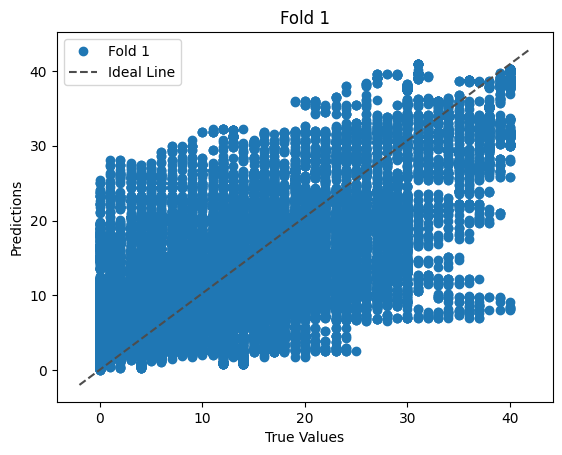

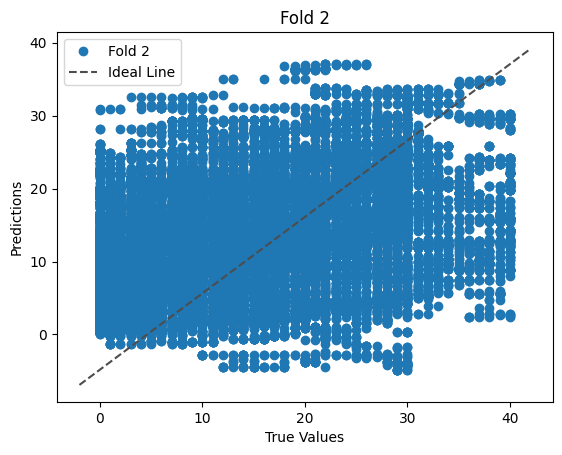

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

def plot_predictions(model, X, y, cv):
    fold = 1
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        fig, ax = plt.subplots()  # Move subplot creation inside the loop
        
        ax.plot(y_test, y_pred, 'o', label=f"Fold {fold}")
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label="Ideal Line")
        ax.set_title(f'Fold {fold}')
        ax.legend()
        
        plt.show()  # Show each plot individually
        
        fold += 1
plot_predictions(gbrt, X, y, cv=ts_cv)

In [20]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


evaluate(
    naive_linear_pipeline, X, y, cv=ts_cv, model_prop="alpha_", model_step="ridgecv"
)

Mean model.alpha_ = 3.1622776601683795
Mean Absolute Error:     6.411 +/- 0.097
Root Mean Squared Error: 7.970 +/- 0.194
R-squared:               0.315 +/- 0.011


In [21]:
predictions = gbrt.predict(X[100:101])
print(predictions)


[5.67527994]


In [22]:
X[:1]

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
0,42,30,broken clouds,7,9.77,2,25,15,7


In [23]:
X[X["station_id"]==100]

,station_id,bike_stands,description,temperature,wind_speed,month,day,hour,weekday_num
69,100,25,broken clouds,7,9.77,2,25,15,7
138,100,25,broken clouds,7,9.77,2,25,15,7
248,100,25,broken clouds,7,9.26,2,25,15,7
404,100,25,broken clouds,7,8.23,2,25,15,7
530,100,25,broken clouds,7,8.23,2,25,15,7
...,...,...,...,...,...,...,...,...,...
751188,100,25,broken clouds,8,6.17,4,2,21,2
751254,100,25,broken clouds,8,6.17,4,2,22,2
751379,100,25,broken clouds,8,6.17,4,2,22,2
751505,100,25,broken clouds,8,6.17,4,2,22,2


In [24]:
times = merged_df.iloc[X[X["station_id"]==100].index]["time_of_day"]
predictions = gbrt.predict(X[X["station_id"]==100])
actual = y[X[X["station_id"]==100].index]

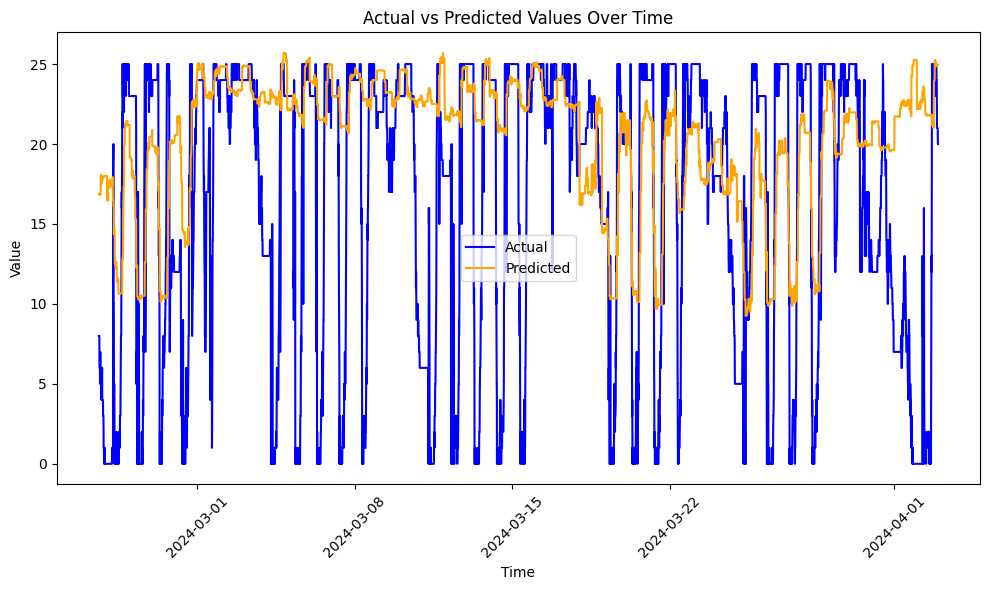

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(times, actual, label='Actual', color='blue')
plt.plot(times, predictions, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [26]:
import requests

import datetime


def fetch_weather_data(lat, lng):
    
    API_KEY = 'e09fe30aecb65a55bb36442eda372b92'
    BASE_URL = f" https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lng}&appid={API_KEY}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None


In [27]:
data = fetch_weather_data(53.3498,-6.2603)


In [28]:
from datetime import datetime
import pandas as pd

datetimes = []
temperatures = []

weather_data = []

for item in data['list']:
    dt = datetime.utcfromtimestamp(item['dt'])
    temp = item['main']['temp'] - 273.15  # Convert temperature from Kelvin to Celsius
    wind_speed = item['wind']['speed']
    description = item['weather'][0]['description']
    weather_data.append({'time_of_day': dt, 'wind_speed': wind_speed, 'temperature': temp, 'description': description})


In [29]:
df = pd.DataFrame(weather_data)

df

,time_of_day,wind_speed,temperature,description
0,2024-04-03 15:00:00,1.73,10.69,light rain
1,2024-04-03 18:00:00,2.52,9.25,overcast clouds
2,2024-04-03 21:00:00,2.34,7.05,light rain
3,2024-04-04 00:00:00,2.19,7.18,light rain
4,2024-04-04 03:00:00,1.75,7.01,light rain
5,2024-04-04 06:00:00,2.45,7.60,overcast clouds
6,2024-04-04 09:00:00,2.87,7.77,light rain
7,2024-04-04 12:00:00,3.38,9.17,light rain
8,2024-04-04 15:00:00,3.86,9.35,overcast clouds
9,2024-04-04 18:00:00,4.21,9.53,overcast clouds


In [30]:
df.set_index('time_of_day', inplace=True)

# Generate hourly datetime range
start_date = df.index.min()
end_date = df.index.max()
hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Reindex the DataFrame with hourly datetime range
df = df.reindex(hourly_range)

# Interpolate missing values
df_interpolated = df.interpolate(method='linear')
         

df_interpolated['description'] = df_interpolated['description'].fillna(method='ffill')
df_interpolated = df_interpolated.iloc[:24]
# Print the interpolated DataFrame
df_interpolated

C:\Users\carlo\AppData\Local\Temp\ipykernel_15684\1355788181.py:12: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear')
C:\Users\carlo\AppData\Local\Temp\ipykernel_15684\1355788181.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated['description'] = df_interpolated['description'].fillna(method='ffill')


,wind_speed,temperature,description
2024-04-03 15:00:00,1.730000,10.690000,light rain
2024-04-03 16:00:00,1.993333,10.210000,light rain
2024-04-03 17:00:00,2.256667,9.730000,light rain
2024-04-03 18:00:00,2.520000,9.250000,overcast clouds
2024-04-03 19:00:00,2.460000,8.516667,overcast clouds
2024-04-03 20:00:00,2.400000,7.783333,overcast clouds
2024-04-03 21:00:00,2.340000,7.050000,light rain
2024-04-03 22:00:00,2.290000,7.093333,light rain
2024-04-03 23:00:00,2.240000,7.136667,light rain
2024-04-04 00:00:00,2.190000,7.180000,light rain


In [31]:
df_interpolated.reset_index(inplace=True)
df_interpolated.rename(columns={'index': 'time_of_day'}, inplace=True)

df_interpolated

,time_of_day,wind_speed,temperature,description
0,2024-04-03 15:00:00,1.730000,10.690000,light rain
1,2024-04-03 16:00:00,1.993333,10.210000,light rain
2,2024-04-03 17:00:00,2.256667,9.730000,light rain
3,2024-04-03 18:00:00,2.520000,9.250000,overcast clouds
4,2024-04-03 19:00:00,2.460000,8.516667,overcast clouds
5,2024-04-03 20:00:00,2.400000,7.783333,overcast clouds
6,2024-04-03 21:00:00,2.340000,7.050000,light rain
7,2024-04-03 22:00:00,2.290000,7.093333,light rain
8,2024-04-03 23:00:00,2.240000,7.136667,light rain
9,2024-04-04 00:00:00,2.190000,7.180000,light rain


In [32]:
def fetch_decaux_data():
    CONTRACT_NAME = "dublin"
    API_KEY = '99d3e65801ab0bdae585264b25d443c5545365b5'
    BASE_URL = f"https://api.jcdecaux.com/vls/v1/stations?contract={CONTRACT_NAME}&apiKey={API_KEY}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
    
station_data = fetch_decaux_data()



In [33]:

# Extracting station_id and bike_stands from each dictionary in the data list
station_df = [{'station_id': d['number'], 'bike_stands': d['bike_stands']} for d in station_data]

# Creating DataFrame
df = pd.DataFrame(station_df)
df_interpolated.reset_index(drop=True, inplace=True)

df

,station_id,bike_stands
0,42,30
1,30,20
2,54,33
3,108,35
4,20,30
...,...,...
109,39,20
110,83,40
111,92,40
112,21,30


In [34]:
df_interpolated

,time_of_day,wind_speed,temperature,description
0,2024-04-03 15:00:00,1.730000,10.690000,light rain
1,2024-04-03 16:00:00,1.993333,10.210000,light rain
2,2024-04-03 17:00:00,2.256667,9.730000,light rain
3,2024-04-03 18:00:00,2.520000,9.250000,overcast clouds
4,2024-04-03 19:00:00,2.460000,8.516667,overcast clouds
5,2024-04-03 20:00:00,2.400000,7.783333,overcast clouds
6,2024-04-03 21:00:00,2.340000,7.050000,light rain
7,2024-04-03 22:00:00,2.290000,7.093333,light rain
8,2024-04-03 23:00:00,2.240000,7.136667,light rain
9,2024-04-04 00:00:00,2.190000,7.180000,light rain


In [35]:
df3 = df_interpolated.merge(df, how ="cross")
df3
df3['time_of_day'] = pd.to_datetime(df3['time_of_day'])
df3['month'] = pd.to_datetime(df3['time_of_day']).dt.month
df3['day'] = pd.to_datetime(df3['time_of_day']).dt.day
df3['hour'] = pd.to_datetime(df3['time_of_day']).dt.hour
df3['weekday_num'] = df3['time_of_day'].dt.weekday + 1  # Adding 1 to match the range 1-7 (Sunday = 7)


df3[df3["station_id"]==42]

,time_of_day,wind_speed,temperature,description,station_id,bike_stands,month,day,hour,weekday_num
0,2024-04-03 15:00:00,1.730000,10.690000,light rain,42,30,4,3,15,3
114,2024-04-03 16:00:00,1.993333,10.210000,light rain,42,30,4,3,16,3
228,2024-04-03 17:00:00,2.256667,9.730000,light rain,42,30,4,3,17,3
342,2024-04-03 18:00:00,2.520000,9.250000,overcast clouds,42,30,4,3,18,3
456,2024-04-03 19:00:00,2.460000,8.516667,overcast clouds,42,30,4,3,19,3
570,2024-04-03 20:00:00,2.400000,7.783333,overcast clouds,42,30,4,3,20,3
684,2024-04-03 21:00:00,2.340000,7.050000,light rain,42,30,4,3,21,3
798,2024-04-03 22:00:00,2.290000,7.093333,light rain,42,30,4,3,22,3
912,2024-04-03 23:00:00,2.240000,7.136667,light rain,42,30,4,3,23,3
1026,2024-04-04 00:00:00,2.190000,7.180000,light rain,42,30,4,4,0,4


In [49]:
predictions = gbrt.predict(df3[df3["station_id"]==10])
times = df3.iloc[df3[df3["station_id"]==10].index]["time_of_day"]


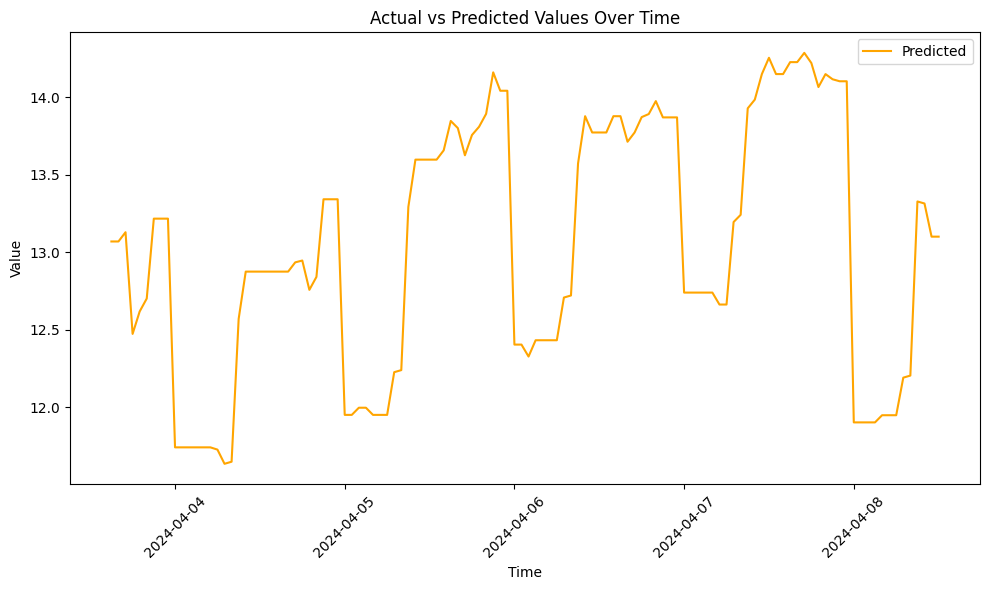

In [50]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(times, predictions, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values Over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [38]:
model.predict(df3[df3["station_id"]==42])

array([13.33953044, 13.92859965, 20.58926106, 26.54126676, 27.4188997 ,
       27.91722088, 28.02379124, 28.02379124, 28.02379124, 28.31372387,
       28.34100736, 28.34100736, 28.34100736, 28.34100736, 28.11391741,
       27.03828901, 25.27311456, 18.57644206, 14.9609113 , 14.9609113 ,
       14.9609113 , 14.9609113 , 14.9609113 , 14.9609113 ])

In [39]:
import requests
from datetime import datetime
import pickle
import pandas as pd


def fetch_weather_data(lat, lng):
    
    API_KEY = 'e09fe30aecb65a55bb36442eda372b92'
    BASE_URL = f" https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lng}&appid={API_KEY}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
    
weather_data = fetch_weather_data(53.3498,-6.2603)

def fetch_decaux_data():
    CONTRACT_NAME = "dublin"
    API_KEY = '99d3e65801ab0bdae585264b25d443c5545365b5'
    BASE_URL = f"https://api.jcdecaux.com/vls/v1/stations?contract={CONTRACT_NAME}&apiKey={API_KEY}"

    response = requests.get(BASE_URL)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
    
station_data = fetch_decaux_data()

In [40]:
weather = [{'time_of_day': datetime.utcfromtimestamp(item['dt']),
            'wind_speed': item['wind']['speed'],
            'temperature': item['main']['temp'] - 273.15,
            'description': item['weather'][0]['description']}
           for item in weather_data['list']]

df = pd.DataFrame(weather)
df

,time_of_day,wind_speed,temperature,description
0,2024-04-03 15:00:00,1.73,10.69,light rain
1,2024-04-03 18:00:00,2.52,9.25,overcast clouds
2,2024-04-03 21:00:00,2.34,7.05,light rain
3,2024-04-04 00:00:00,2.19,7.18,light rain
4,2024-04-04 03:00:00,1.75,7.01,light rain
5,2024-04-04 06:00:00,2.45,7.60,overcast clouds
6,2024-04-04 09:00:00,2.87,7.77,light rain
7,2024-04-04 12:00:00,3.38,9.17,light rain
8,2024-04-04 15:00:00,3.86,9.35,overcast clouds
9,2024-04-04 18:00:00,4.21,9.53,overcast clouds


In [41]:

# Generate hourly datetime range
start_date = df["time_of_day"].min()
end_date = df["time_of_day"].max()
hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')
df = df.set_index('time_of_day').reindex(hourly_range).reset_index()
df.rename(columns={'index': 'time_of_day'}, inplace=True)
df_interpolated = df.interpolate(method='linear')
df_interpolated['description'] = df_interpolated['description'].fillna(method='ffill')
df_interpolated

C:\Users\carlo\AppData\Local\Temp\ipykernel_15684\624263842.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear')
C:\Users\carlo\AppData\Local\Temp\ipykernel_15684\624263842.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_interpolated['description'] = df_interpolated['description'].fillna(method='ffill')


,time_of_day,wind_speed,temperature,description
0,2024-04-03 15:00:00,1.730000,10.690000,light rain
1,2024-04-03 16:00:00,1.993333,10.210000,light rain
2,2024-04-03 17:00:00,2.256667,9.730000,light rain
3,2024-04-03 18:00:00,2.520000,9.250000,overcast clouds
4,2024-04-03 19:00:00,2.460000,8.516667,overcast clouds
...,...,...,...,...
113,2024-04-08 08:00:00,6.903333,11.483333,overcast clouds
114,2024-04-08 09:00:00,6.740000,12.030000,overcast clouds
115,2024-04-08 10:00:00,7.596667,11.726667,overcast clouds
116,2024-04-08 11:00:00,8.453333,11.423333,overcast clouds


In [42]:

# Creating DataFrame
df = pd.DataFrame([{'station_id': d['number'], 'bike_stands': d['bike_stands']} for d in station_data])


df3 = df_interpolated.merge(df, how ="cross")

df3['month'] = pd.to_datetime(df3['time_of_day']).dt.month
df3['day'] = pd.to_datetime(df3['time_of_day']).dt.day
df3['hour'] = pd.to_datetime(df3['time_of_day']).dt.hour
df3['weekday_num'] = df3['time_of_day'].dt.weekday + 1  # Adding 1 to match the range 1-7 (Sunday = 7)


df3

,time_of_day,wind_speed,temperature,description,station_id,bike_stands,month,day,hour,weekday_num
0,2024-04-03 15:00:00,1.73,10.69,light rain,42,30,4,3,15,3
1,2024-04-03 15:00:00,1.73,10.69,light rain,30,20,4,3,15,3
2,2024-04-03 15:00:00,1.73,10.69,light rain,54,33,4,3,15,3
3,2024-04-03 15:00:00,1.73,10.69,light rain,108,35,4,3,15,3
4,2024-04-03 15:00:00,1.73,10.69,light rain,20,30,4,3,15,3
...,...,...,...,...,...,...,...,...,...,...
13447,2024-04-08 12:00:00,9.31,11.12,light rain,39,20,4,8,12,1
13448,2024-04-08 12:00:00,9.31,11.12,light rain,83,40,4,8,12,1
13449,2024-04-08 12:00:00,9.31,11.12,light rain,92,40,4,8,12,1
13450,2024-04-08 12:00:00,9.31,11.12,light rain,21,30,4,8,12,1


In [43]:

def predict_bike_availability(df):
    # Load the pre-trained model
    with open('your_model.pkl', 'rb') as file:
        model = pickle.load(file)
    
    # Predict bike availability using the model
    predictions = model.predict(df)
    
    return predictions